In [26]:
import pandas as pd
import numpy as np 
import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pprint 


In [27]:
tag = pd.read_csv(r'C:\Users\ck261\Documents\data-mining\tp\ml-latest-small\ml-latest-small\tags.csv')
link = pd.read_csv(r'C:\Users\ck261\Documents\data-mining\tp\ml-latest-small\ml-latest-small\links.csv')
movie = pd.read_csv(r'C:\Users\ck261\Documents\data-mining\tp\ml-latest-small\ml-latest-small\movies.csv')
rating = pd.read_csv(r'C:\Users\ck261\Documents\data-mining\tp\ml-latest-small\ml-latest-small\ratings.csv')

In [28]:
user_ids = rating["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = rating["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
rating["user"] = rating["userId"].map(user2user_encoded)
rating["movie"] = rating["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
rating["rating"] = rating["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(rating["rating"])
max_rating = max(rating["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)


Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


In [29]:
df = rating.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)


In [47]:
from recommender import RecommenderNet

# 50 dimensional vectors

model = RecommenderNet(num_users, num_movies, embedding_size=50)

sgd = tf.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.0, nesterov=False, name="SGD"
)

rmse = tf.keras.metrics.RootMeanSquaredError(
    name='root_mean_squared_error', dtype=None
)

model.compile(
    loss=rmse, optimizer=sgd
)


In [48]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)


Epoch 1/5
1418/1418 [==============================] - 16s 11ms/step - loss: 0.2856 - root_mean_squared_error: 0.2861 - val_loss: 0.2873 - val_root_mean_squared_error: 0.2859
Epoch 2/5
1418/1418 [==============================] - 13s 9ms/step - loss: 0.2862 - root_mean_squared_error: 0.2862 - val_loss: 0.2873 - val_root_mean_squared_error: 0.2859
Epoch 3/5
1418/1418 [==============================] - 12s 9ms/step - loss: 0.2854 - root_mean_squared_error: 0.2861 - val_loss: 0.2873 - val_root_mean_squared_error: 0.2859
Epoch 4/5
1418/1418 [==============================] - 13s 9ms/step - loss: 0.2868 - root_mean_squared_error: 0.2861 - val_loss: 0.2873 - val_root_mean_squared_error: 0.2859
Epoch 5/5
1418/1418 [==============================] - 13s 9ms/step - loss: 0.2858 - root_mean_squared_error: 0.2861 - val_loss: 0.2873 - val_root_mean_squared_error: 0.2859


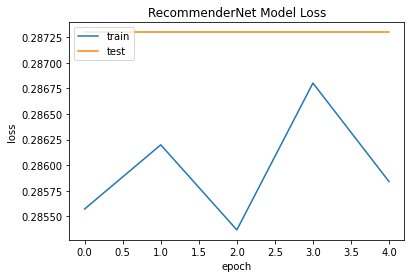

In [49]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("RecommenderNet Model Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


In [44]:
movie_df = movie

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(2).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)


Showing recommendations for user: 480
Movies with high ratings from user
--------------------------------
Godfather, The (1972) : Crime|Drama
Back to the Future (1985) : Adventure|Comedy|Sci-Fi
Last of the Mohicans, The (1992) : Action|Romance|War|Western
Cider House Rules, The (1999) : Drama
Baraka (1992) : Documentary
--------------------------------
Top 10 movie recommendations
--------------------------------
Dangerous Beauty (1998) : Drama
King and I, The (1956) : Drama|Musical|Romance
Walk on the Moon, A (1999) : Drama|Romance
Twin Dragons (Shuang long hui) (1992) : Action|Comedy
Cookie's Fortune (1999) : Comedy|Drama
Life (1999) : Comedy|Crime|Drama
Lost & Found (1999) : Comedy|Romance
eXistenZ (1999) : Action|Sci-Fi|Thriller
Journey to the West: Conquering the Demons (Daai wa sai you chi Chui mo chun kei) (2013) : Adventure|Comedy|Fantasy|Romance|IMAX
Maniac Cop 2 (1990) : Action|Horror|Thriller
